In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stage2_sample_submission_final.csv', 'stage1_test', 'stage1_train_labels.csv', 'stage1_train', 'stage1_sample_submission.csv', 'stage2_test_final']


In [2]:
## Imports
import os
import sys
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
image_size = 128
train_path = "../input/stage1_train/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


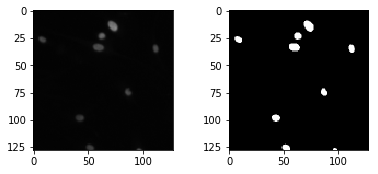

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_____________________________________

In [10]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
83/83 [==============================] - 96s 1s/step - loss: 2.9645 - acc: 0.8464 - val_loss: 2.1286 - val_acc: 0.7881
Epoch 2/5
83/83 [==============================] - 48s 578ms/step - loss: 0.9890 - acc: 0.8678 - val_loss: 0.4045 - val_acc: 0.8965
Epoch 3/5
83/83 [==============================] - 48s 577ms/step - loss: 0.5838 - acc: 0.9266 - val_loss: 0.3116 - val_acc: 0.9188
Epoch 4/5
83/83 [==============================] - 48s 579ms/step - loss: 0.4746 - acc: 0.9388 - val_loss: 0.3548 - val_acc: 0.9116
Epoch 5/5
83/83 [==============================] - 48s 579ms/step - loss: 0.4327 - acc: 0.9436 - val_loss: 0.2476 - val_acc: 0.9294


In [11]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

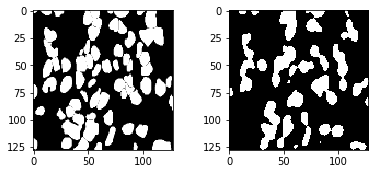

In [12]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

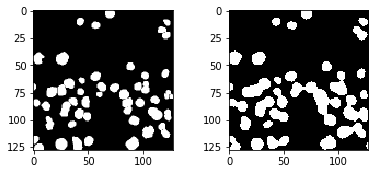

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")